In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import linear_model

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib widget

In [5]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\echo_analysis'

### Load excel sheet with metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Choose subject

In [7]:
data_loc = r"F:\ZZmanuscript_eLife\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1"
exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
expname = data_loc[data_loc.find('mouse')+12:data_loc.find('experiment')-1]
print(expname)

Experiment type: electrical and sensory stimulation
estim_vis_2021-04-08_10-28-24


In [8]:
## Grab exp metadata from Templeton-log_exp ##
if np.any([True if exp.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
    exp_meta = Temp_metadata[(
        (Temp_metadata['mouse_name'].str.contains(exp.mouse)) & (Temp_metadata['exp_name'].str.contains(expname))
    )].squeeze()
elif np.any([True if exp.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
    exp_meta = ZZ_metadata[(
        (ZZ_metadata['mouse_name'].str.contains(exp.mouse)) & (ZZ_metadata['exp_name'].str.contains(expname))
    )].squeeze()
else:
    print('Cannot find {}: {} in the experiment log excel sheets.'.format(exp.mouse, expname))

In [9]:
print(exp_meta['brain states'])

awake/ISO/recovery/recovery


In [10]:
sweep_state_list = ['awake', 'isoflurane', 'recovery', 'recovery']

In [11]:
## Get bad EEG channels ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)

[]


In [12]:
## Load stim log and apply sweep labels ##
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial,state
0,biphasic,40,375.08634,375.08674,0.0004,0,True,0.0,True,awake
1,biphasic,15,378.61936,378.61976,0.0004,0,True,0.0,True,awake
2,biphasic,40,382.68098,382.68138,0.0004,0,True,0.0,True,awake
3,biphasic,60,387.06326,387.06366,0.0004,0,True,0.0,True,awake
4,biphasic,60,391.23287,391.23327,0.0004,0,True,0.0,True,awake


In [13]:
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
else:
    estim_current = {'mid': str(currents[0])}
print(estim_current)

{'low': '15', 'mid': '40', 'high': '60'}


In [14]:
## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [15]:
print(all_EEG_traces.shape)
print(len(stim_log))

(10000, 30, 1920)
1920


In [16]:
manual_1stpk_annots_file = os.path.join(exp.data_folder, 'manual_first_peak_detection.npy')
if os.path.exists(manual_1stpk_annots_file):
    annots = np.load(os.path.join(exp.data_folder, 'manual_first_peak_detection.npy'))
    print(len(annots))
else:
    print('No annotations file found.')

1876


In [17]:
np.nonzero(annots > 1)

(array([1288], dtype=int64),)

#### Plot one trial

In [18]:
stim_log[1280:1292]

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial,state
1280,biphasic,60,7280.64072,7280.64112,0.0004,2,True,0.0,True,recovery
1281,biphasic,40,7284.87898,7284.87938,0.0004,2,True,0.0,True,recovery
1282,biphasic,15,7288.44279,7288.44319,0.0004,2,True,0.0,True,recovery
1283,biphasic,40,7292.80366,7292.80406,0.0004,2,True,0.0,True,recovery
1284,biphasic,60,7297.23848,7297.23888,0.0004,2,True,0.0,True,recovery
1285,biphasic,15,7301.72330,7301.72370,0.0004,2,True,0.0,True,recovery
1286,biphasic,15,7306.08266,7306.08306,0.0004,2,True,0.0,True,recovery
1287,biphasic,15,7310.36864,7310.36904,0.0004,2,True,0.0,True,recovery
1288,biphasic,15,7314.38244,7314.38284,0.0004,2,True,0.0,True,recovery
1289,biphasic,60,7318.06046,7318.06086,0.0004,2,True,0.0,True,recovery


Isoflurane from 480-840

Plan: use GFP to determine if there are 1st and 2nd peaks. Then find the max of the peak of rectified mean???

Text(0.5, 1.0, 'Single trial EP (raw)\ntrial 4: biphasic-60uA (awake)')

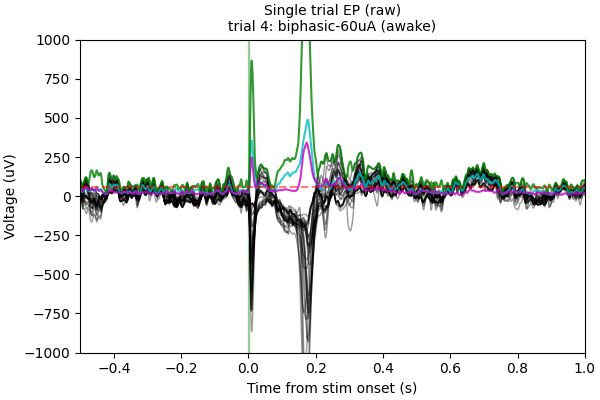

In [19]:
triali = 4
trialtraces = all_EEG_traces[:,:,triali]
rect_mean = np.mean(np.abs(trialtraces[:, GOOD_CHS]), axis=1)
gfpow = np.std(trialtraces[:, GOOD_CHS], axis=1)
maxis = np.max(np.abs(trialtraces[:, GOOD_CHS]), axis=1)

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.plot(EEG_event_timestamps, trialtraces, c='k', linewidth=1.0, alpha=0.4)
ax.plot(EEG_event_timestamps, rect_mean, c='c', linewidth=1.5, alpha=0.8)
ax.plot(EEG_event_timestamps, gfpow, c='m', linewidth=1.5, alpha=0.8)
ax.plot(EEG_event_timestamps, maxis, c='g', linewidth=1.5, alpha=0.8)

baseline_gfp = gfpow[EEG_event_timestamps < 0]
ax.axhline(np.mean(baseline_gfp) + (3 * np.std(baseline_gfp)), color='r', linestyle='dashed', alpha=0.5)

ax.set_xlim([-0.5, 1.0])
ax.set_ylim([-1000, 1000])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Single trial EP (raw)\ntrial {:d}: {}-{}uA ({})'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter, stim_log.iloc[triali].state))

### Plotting multiple trials

In [20]:
## Choose windows ##
windows = {'first': [0.002, 0.025], 'second': [0.1, 0.25]}
## Simone: 'early': [0.003, 0.05], 'late': [0.15, 0.25]

In [21]:
all_rectmean = np.mean(np.abs(all_EEG_traces[:, GOOD_CHS, :]), axis=1)
print(all_rectmean.shape)

(10000, 1920)


In [22]:
all_gfp = np.std(all_EEG_traces[:, GOOD_CHS, :], axis=1)
print(all_gfp.shape)

(10000, 1920)


Calculating peaks of rectified mean

In [23]:
pkmaxs = {}
blmaxs = {}
for winname, windowi in windows.items():
    testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
    blinds = np.nonzero((EEG_event_timestamps >= -windowi[1]) & (EEG_event_timestamps <= -windowi[0]))[0]
    pkmaxs[winname] = np.max(all_rectmean[testinds, :], axis=0)
    blmaxs[winname] = np.max(all_rectmean[blinds, :], axis=0)

Calculating z-values of global field power

In [24]:
all_mean_gfp = np.mean(all_gfp[EEG_event_timestamps < 0, :], axis=0)
all_std_gfp = np.std(all_gfp[EEG_event_timestamps < 0, :], axis=0)

fwinds = np.nonzero((EEG_event_timestamps >= windows['first'][0]) & (EEG_event_timestamps <= windows['first'][1]))[0]
all_firstpeakmax = np.max(all_gfp[fwinds, :], axis=0)
all_firstpeakz = (all_firstpeakmax - all_mean_gfp) / all_std_gfp
print(all_firstpeakz.shape)
first_peak_zthresh = 3

(1920,)


Plotting

Text(0.5, 0.98, 'Single trial EP (raw) trial 18: biphasic-40uA')

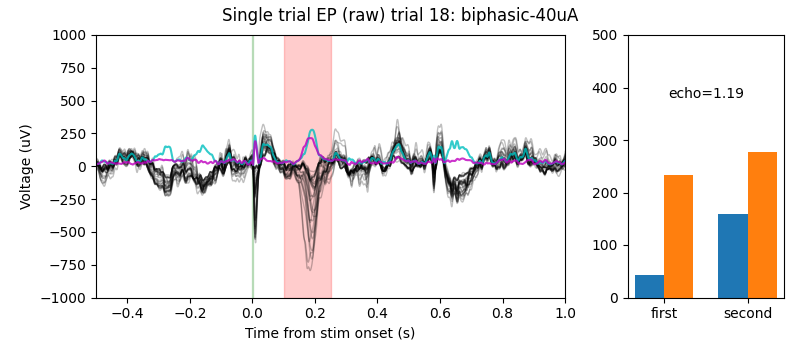

In [25]:
triali = 18
trialtraces = all_EEG_traces[:,:,triali]
recttrace = all_rectmean[:,triali]
gfptrace = all_gfp[:,triali]

fig = plt.figure(figsize=(8, 3.5))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3,1], left=0.12, right=0.98, top=0.9, bottom=0.15, wspace=0.2)
axEEG = fig.add_subplot(gs[0])
axpks = fig.add_subplot(gs[1])

axEEG.axvspan(0, 0.002, color='g', alpha=0.2)
axEEG.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
axEEG.plot(EEG_event_timestamps, trialtraces, c='k', linewidth=1.0, alpha=0.25)
axEEG.plot(EEG_event_timestamps, recttrace, c='c', linewidth=1.5, alpha=0.8)
axEEG.plot(EEG_event_timestamps, gfptrace, c='m', linewidth=1.5, alpha=0.8)
axEEG.set_xlim([-0.5, 1.0])
axEEG.set_ylim([-1000, 1000])
axEEG.set_xlabel('Time from stim onset (s)')
axEEG.set_ylabel('Voltage (uV)')

xb = np.arange(len(windows))
wd = 0.35
axpks.bar(xb - wd/2, [blmaxs['first'][triali], blmaxs['second'][triali]], wd)
axpks.bar(xb + wd/2, [pkmaxs['first'][triali], pkmaxs['second'][triali]], wd)
axpks.set_xticks(xb)
axpks.set_xticklabels(['first', 'second'])
axpks.set_ylim([0, 500])
echoi = pkmaxs['second'][triali] / pkmaxs['first'][triali]
axpks.annotate('echo={:.2f}'.format(echoi), xy=(0.5, 400), ha='center', va='top', color='k')

fig.suptitle('Single trial EP (raw) trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

<ErrorbarContainer object of 3 artists>

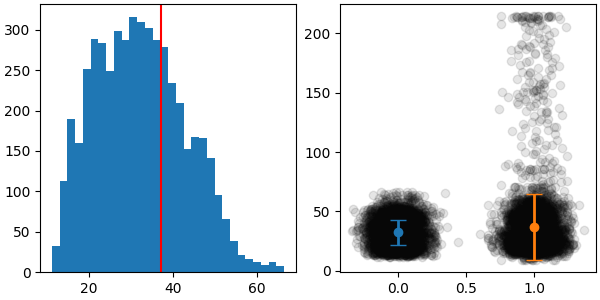

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
blvals = gfptrace[EEG_event_timestamps < 0]
epvals = gfptrace[EEG_event_timestamps > 0]

axs[0].hist(blvals)
axs[0].axvline(np.mean(epvals), color='r')

x0s = np.random.normal(0, 0.1, len(blvals))
axs[1].scatter(x0s, blvals, c='k', marker='o', alpha=0.1)
axs[1].errorbar(0, np.mean(blvals), np.std(blvals), fmt='o', linewidth=2, capsize=6)

x1s = np.random.normal(1, 0.1, len(epvals))
axs[1].scatter(x1s, epvals, c='k', marker='o', alpha=0.1)
axs[1].errorbar(1, np.mean(epvals), np.std(epvals), fmt='o', linewidth=2, capsize=6)

Text(0.5, 1.0, 'Single trial EP (raw) trial 18: biphasic-40uA')

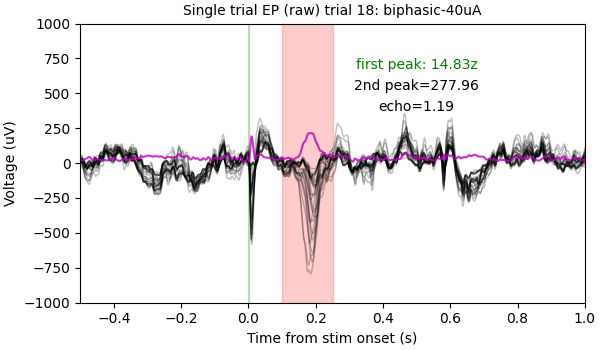

In [25]:
triali = 18
trialtraces = all_EEG_traces[:,:,triali]
gfptrace = all_gfp[:,triali]

fig, ax = plt.subplots(figsize=(6,3.5), constrained_layout=True)

ax.axvspan(0, 0.002, color='g', alpha=0.2)
ax.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
ax.plot(EEG_event_timestamps, trialtraces, c='k', linewidth=1.0, alpha=0.25)
ax.plot(EEG_event_timestamps, gfptrace, c='m', linewidth=1.5, alpha=0.8)
ax.set_xlim([-0.5, 1.0])
ax.set_ylim([-1000, 1000])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')

if all_firstpeakz[triali] > first_peak_zthresh:
    ax.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='g')
    echoi = pkmaxs['second'][triali] / pkmaxs['first'][triali]
    ax.annotate('2nd peak={:.2f}'.format(pkmaxs['second'][triali]), xy=(0.5, 600), ha='center', va='top', color='k')
    ax.annotate('echo={:.2f}'.format(echoi), xy=(0.5, 450), ha='center', va='top', color='k')
else:
    ax.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='r')

ax.set_title('Single trial EP (raw) trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

##### Plot several trials

Awake

Text(0.5, 0.98, 'Single trial EPs (raw): awake')

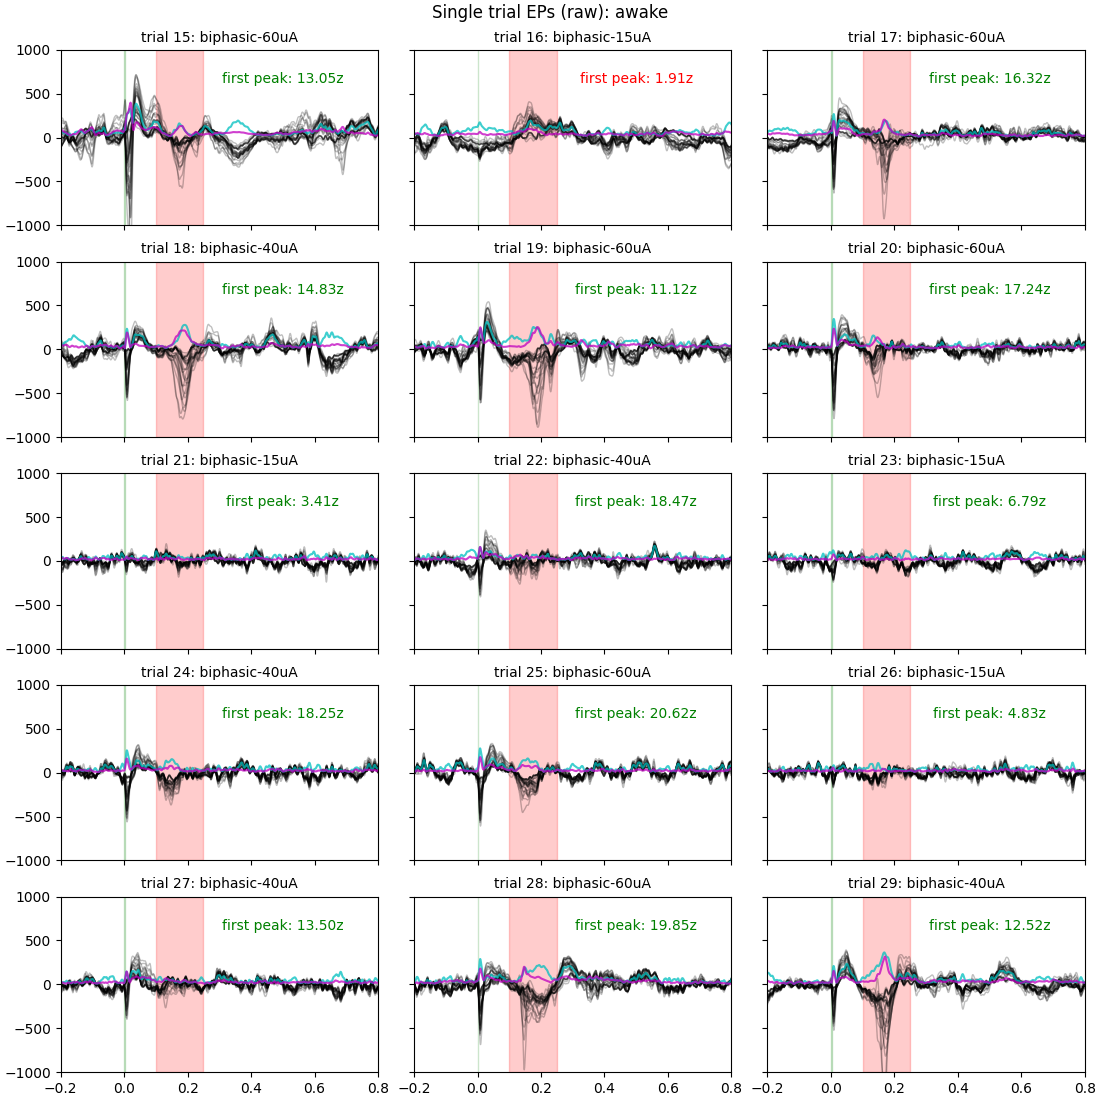

In [26]:
itrial = 15

fig, axs = plt.subplots(5, 3, figsize=(11,11), constrained_layout=True, sharex=True, sharey=True)

for axi, triali in zip(axs.flatten(), range(itrial, itrial+15)):
    axi.axvspan(0, 0.002, color='g', alpha=0.2)
    axi.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
    axi.plot(EEG_event_timestamps, all_EEG_traces[:,:,triali], c='k', linewidth=1.0, alpha=0.25)
    axi.plot(EEG_event_timestamps, all_rectmean[:,triali], c='c', linewidth=1.5, alpha=0.75)
    axi.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.75)
    axi.set_title('trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

    if all_firstpeakz[triali] > first_peak_zthresh:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='g')
    else:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='r')

axi.set_xlim([-0.2, 0.8])
axi.set_ylim([-1000, 1000])
plt.suptitle('Single trial EPs (raw): awake')

Isoflurane

Text(0.5, 0.98, 'Single trial EPs (raw): iso')

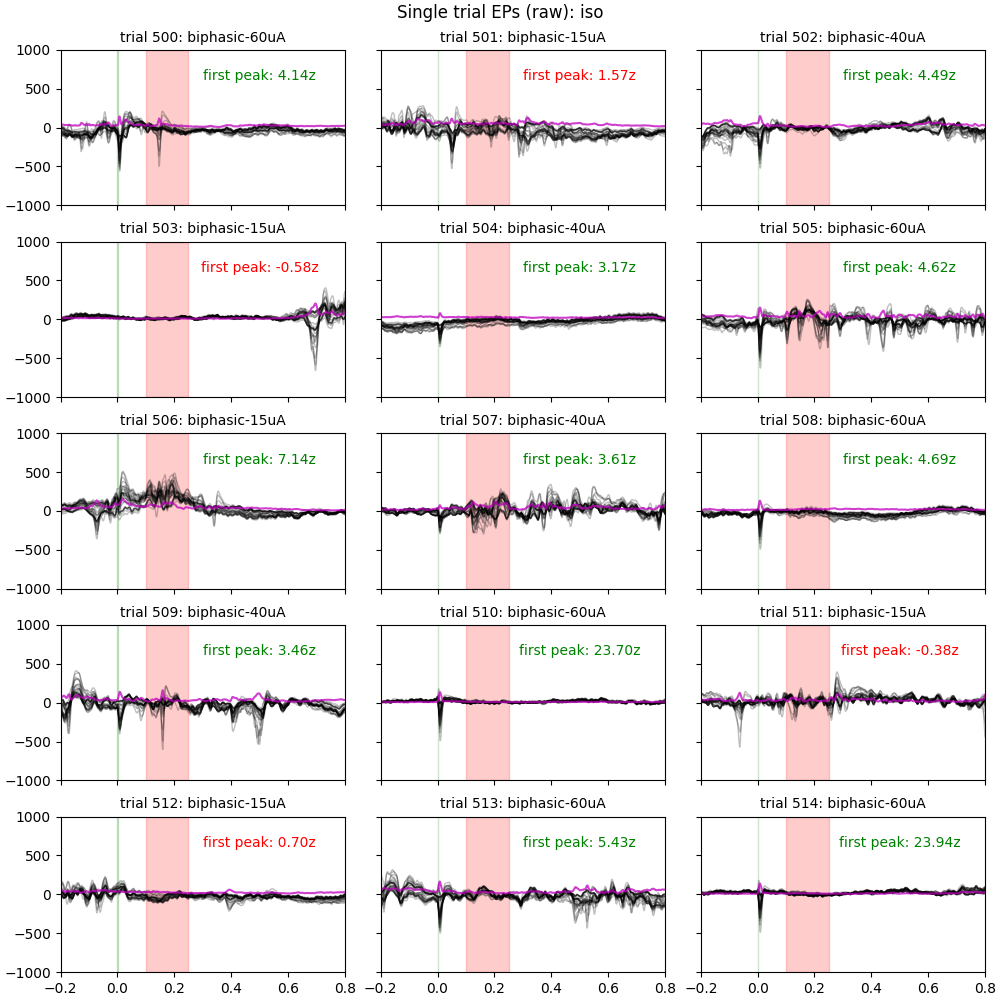

In [27]:
itrial = 500 # 480

fig, axs = plt.subplots(5, 3, figsize=(10,10), constrained_layout=True, sharex=True, sharey=True)

for axi, triali in zip(axs.flatten(), range(itrial, itrial+15)):
    axi.axvspan(0, 0.002, color='g', alpha=0.2)
    axi.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
    axi.plot(EEG_event_timestamps, all_EEG_traces[:,:,triali], c='k', linewidth=1.0, alpha=0.25)
    axi.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.75)
    axi.set_title('trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

    if all_firstpeakz[triali] > first_peak_zthresh:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='g')
    else:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='r')

axi.set_xlim([-0.2, 0.8])
axi.set_ylim([-1000, 1000])
plt.suptitle('Single trial EPs (raw): iso')

#### Plot fraction of trials that have 1st peak greater than z threshold

In [23]:
comp_states = ['awake', 'isoflurane']
fractions = np.zeros((len(comp_states), len(estim_current)), dtype=float)
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        print('{} - {}'.format(statei, parami))
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        fractions[ri,ci] = np.sum(all_firstpeakz[eventinds] > first_peak_zthresh) / len(eventinds)

awake - 15
awake - 40
awake - 60
isoflurane - 15
isoflurane - 40
isoflurane - 60


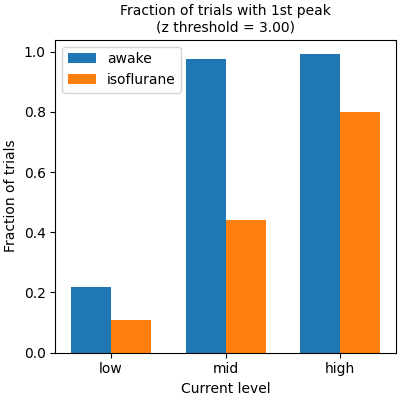

In [24]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
x = np.arange(len(estim_current))  # the label locations
width = 0.35  # the width of the bars
ax.bar(x - width/2, fractions[0,:], width, label=comp_states[0])
ax.bar(x + width/2, fractions[1,:], width, label=comp_states[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of trials')
ax.set_ylim([0, 1.04])
ax.set_title('Fraction of trials with 1st peak\n(z threshold = {:.2f})'.format(first_peak_zthresh))
ax.set_xticks(x)
ax.set_xticklabels(estim_current.keys())
ax.set_xlabel('Current level')
ax.legend()

#### Plot actual z values of 1st peak

awake - 15
awake - 40
awake - 60
isoflurane - 15
isoflurane - 40
isoflurane - 60


[Text(0.5, 0, 'low'), Text(3.5, 0, 'mid'), Text(6.5, 0, 'high')]

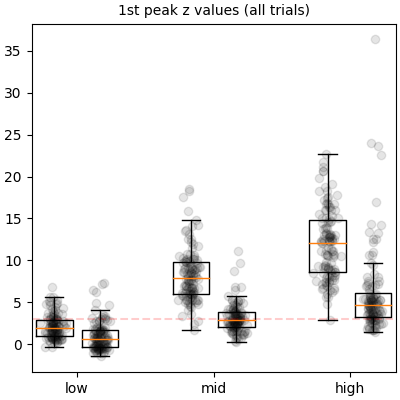

In [25]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
blocs = np.arange(len(estim_current) * (len(comp_states) + 1)).reshape((len(comp_states) + 1), len(estim_current))
ax.axhline(first_peak_zthresh, color='r', linestyle='dashed', alpha=0.2)
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        print('{} - {}'.format(statei, parami))
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        y_values = all_firstpeakz[eventinds]
        x_values = np.random.normal(blocs[ci,ri], 0.1, len(y_values))
        ax.scatter(x_values, y_values, c='k', marker='o', alpha=0.1)
        ax.boxplot(y_values, positions=[blocs[ci,ri]], widths=[0.8], showfliers=False)
ax.set_title('1st peak z values (all trials)')
ax.set_xticks(np.mean(blocs[:,:-1], axis=1))
ax.set_xticklabels(estim_current.keys())

### Using sklearn

In [26]:
comp_states = ['awake', 'isoflurane']
temp_zvals = []
temp_annots = []
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        print('{} - {}'.format(statei, parami))
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        temp_zvals.append(all_firstpeakz[eventinds])
        temp_annots.append(annots[eventinds])

firstpk_zvals = np.array(temp_zvals).flatten()
firstpk_annots = np.array(temp_annots).flatten()

awake - 15
awake - 40
awake - 60
isoflurane - 15
isoflurane - 40
isoflurane - 60


In [27]:
print(firstpk_zvals.shape)
print(firstpk_annots.shape)

(720,)
(720,)


In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(firstpk_zvals, firstpk_annots, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [35]:
# Train a classifier (Logistic Regression)
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [37]:
# Get the predicted probabilities for the test set
y_prob = model.predict(X_test)[:]  # Get probabilities for the positive class

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [39]:
thresholds[np.argmax(tpr - fpr)]

0.652342910630875

In [42]:
(np.max(firstpk_zvals) - np.min(firstpk_zvals)) * thresholds[np.argmax(tpr - fpr)]

24.664989361870745

This is using the global field power (GFP) to detect the presence of a 1st peak. If the max GFP within [0, 0.025] s exceeds 3 standard deviations above the baseline GFP values (from [-2.0, 0] s), then the trial is considered to have a 1st peak.
<br>For mouse 569064, this appears to be working as expected: mid and high currents evoke a first peak almost every trial in the awake state and there are fewer trials with detected first peaks in the isoflurane state.

### How to measure the echo??

Can just take the max within the windows of 1st and 2nd peak? Try it to see if it is working well? try AUCs??

In [31]:
calc_data = all_rectmean # try all_gfp or all_rectmean
all_2ndpeak_metrics = {}

swinds = np.nonzero((EEG_event_timestamps >= windows['second'][0]) & (EEG_event_timestamps <= windows['second'][1]))[0]
# blinds = np.nonzero((EEG_event_timestamps >= -windows['second'][1]) & (EEG_event_timestamps <= -windows['second'][0]))[0]

all_2ndpeak_metrics['max'] = np.max(calc_data[swinds, :], axis=0)
all_2ndpeak_metrics['mean'] = np.mean(calc_data[swinds, :], axis=0)

## Area under EP curve, did not subtract baseline here ##
all_2ndpeak_metrics['auc'] = integrate.simps(calc_data[swinds, :], EEG_event_timestamps[swinds], axis=0, even='last')

In [32]:
calc_data = all_gfp # try all_gfp or all_rectmean
all_2ndpeak_metrics2 = {}

swinds = np.nonzero((EEG_event_timestamps >= windows['second'][0]) & (EEG_event_timestamps <= windows['second'][1]))[0]
# blinds = np.nonzero((EEG_event_timestamps >= -windows['second'][1]) & (EEG_event_timestamps <= -windows['second'][0]))[0]

all_2ndpeak_metrics2['max'] = np.max(calc_data[swinds, :], axis=0)
all_2ndpeak_metrics2['mean'] = np.mean(calc_data[swinds, :], axis=0)

## Area under EP curve, did not subtract baseline here ##
all_2ndpeak_metrics2['auc'] = integrate.simps(calc_data[swinds, :], EEG_event_timestamps[swinds], axis=0, even='last')

#### Compare using rectified mean to using GFP

Text(0.5, 1.0, '2nd peak AUC')

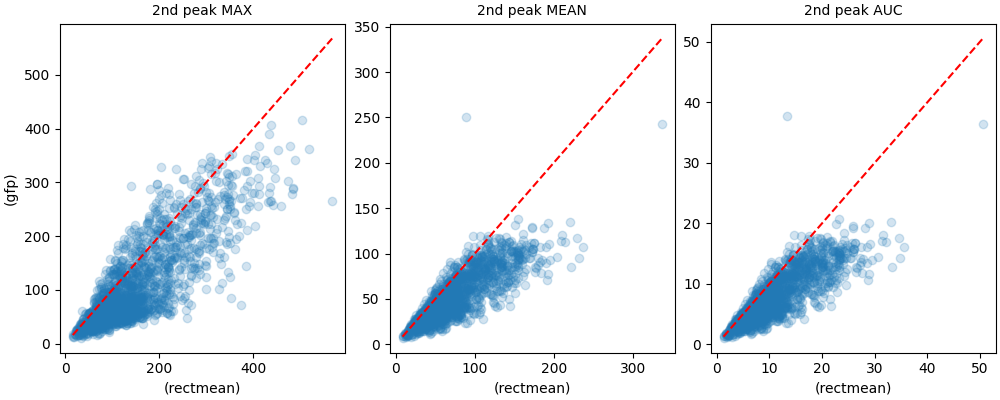

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True)

axs[0].scatter(x=all_2ndpeak_metrics['max'], y=all_2ndpeak_metrics2['max'], alpha=0.2)
axs[0].set_xlabel('(rectmean)')
axs[0].set_ylabel('(gfp)')
axs[0].plot(
    [all_2ndpeak_metrics['max'].min(), all_2ndpeak_metrics['max'].max()], [all_2ndpeak_metrics['max'].min(), all_2ndpeak_metrics['max'].max()],
    color='r', linestyle='dashed')
axs[0].set_title('2nd peak MAX')

axs[1].scatter(x=all_2ndpeak_metrics['mean'], y=all_2ndpeak_metrics2['mean'], alpha=0.2)
axs[1].set_xlabel('(rectmean)')
axs[1].plot(
    [all_2ndpeak_metrics['mean'].min(), all_2ndpeak_metrics['mean'].max()], [all_2ndpeak_metrics['mean'].min(), all_2ndpeak_metrics['mean'].max()],
    color='r', linestyle='dashed')
axs[1].set_title('2nd peak MEAN')

axs[2].scatter(x=all_2ndpeak_metrics['auc'], y=all_2ndpeak_metrics2['auc'], alpha=0.2)
axs[2].set_xlabel('(rectmean)')
axs[2].plot(
    [all_2ndpeak_metrics['auc'].min(), all_2ndpeak_metrics['auc'].max()], [all_2ndpeak_metrics['auc'].min(), all_2ndpeak_metrics['auc'].max()],
    color='r', linestyle='dashed')
axs[2].set_title('2nd peak AUC')

With either metric, using the rectified mean leads to higher values compared to using the GFP.

#### Compare the metrics to each other

Text(0.5, 1.0, 'MEAN v AUC')

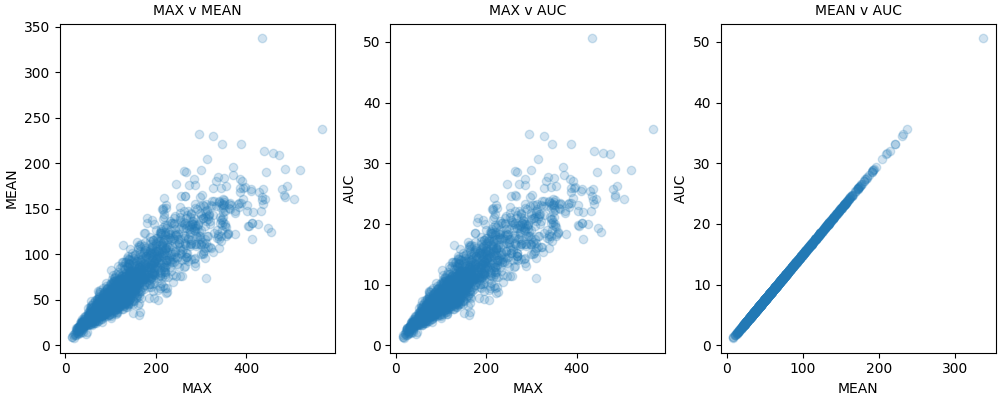

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True)

axs[0].scatter(x=all_2ndpeak_metrics['max'], y=all_2ndpeak_metrics['mean'], alpha=0.2)
axs[0].set_xlabel('MAX')
axs[0].set_ylabel('MEAN')
# axs[0].plot(
#     [all_2ndpeak_metrics['max'].min(), all_2ndpeak_metrics['max'].max()], [all_2ndpeak_metrics['max'].min(), all_2ndpeak_metrics['max'].max()],
#     color='r', linestyle='dashed')
axs[0].set_title('MAX v MEAN')

axs[1].scatter(x=all_2ndpeak_metrics['max'], y=all_2ndpeak_metrics['auc'], alpha=0.2)
axs[1].set_xlabel('MAX')
axs[1].set_ylabel('AUC')
# axs[1].plot(
#     [all_2ndpeak_metrics['max'].min(), all_2ndpeak_metrics['max'].max()], [all_2ndpeak_metrics['max'].min(), all_2ndpeak_metrics['max'].max()],
#     color='r', linestyle='dashed')
axs[1].set_title('MAX v AUC')

axs[2].scatter(x=all_2ndpeak_metrics['mean'], y=all_2ndpeak_metrics['auc'], alpha=0.2)
axs[2].set_xlabel('MEAN')
axs[2].set_ylabel('AUC')
# axs[2].plot(
#     [all_2ndpeak_metrics['mean'].min(), all_2ndpeak_metrics['mean'].max()], [all_2ndpeak_metrics['mean'].min(), all_2ndpeak_metrics['mean'].max()],
#     color='r', linestyle='dashed')
axs[2].set_title('MEAN v AUC')

Mean and AUC are perfectly correlated. Max peak gives the highest value overall. I don't think this helps answer which metric is most informative.

awake - 15
awake - 40
awake - 60
isoflurane - 15
isoflurane - 40
isoflurane - 60


Text(0.5, 1.0, 'MAX v MEAN')

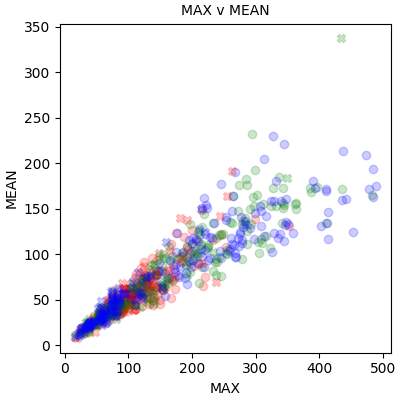

In [47]:
comp_states = ['awake', 'isoflurane']
csizes = ['red', 'green', 'blue']
shapes = ['o', 'X']

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        print('{} - {}'.format(statei, parami))
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        ax.scatter(x=all_2ndpeak_metrics['max'][eventinds], y=all_2ndpeak_metrics['mean'][eventinds], marker=shapes[ri], c=csizes[ci], alpha=0.2)
ax.set_xlabel('MAX')
ax.set_ylabel('MEAN')
ax.set_title('MAX v MEAN')

This doesn't really help either, I guess we can use max of the rectified mean within the target window.

#### Compare values across all trial types
<br> Max value appears to differentiate the states slightly better than the mean value.

[Text(0.5, 0, 'low'), Text(3.5, 0, 'mid'), Text(6.5, 0, 'high')]

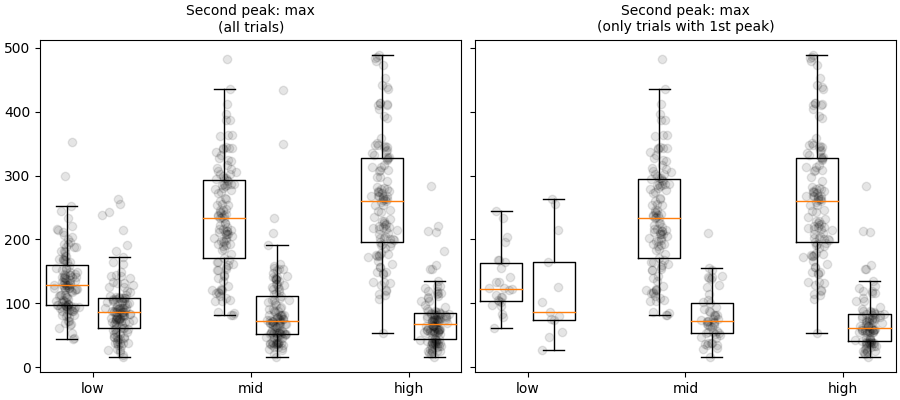

In [65]:
pmetric = 'max'
comp_states = ['awake', 'isoflurane']
fig, axs = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True, sharey=True)
blocs = np.arange(len(estim_current) * (len(comp_states) + 1)).reshape((len(comp_states) + 1), len(estim_current))
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        y_values = all_2ndpeak_metrics[pmetric][eventinds]
        x_values = np.random.normal(blocs[ci,ri], 0.1, len(y_values))
        axs[0].scatter(x_values, y_values, c='k', marker='o', alpha=0.1)
        axs[0].boxplot(y_values, positions=[blocs[ci,ri]], widths=[0.8], showfliers=False)

        firstpeak_mask = all_firstpeakz[eventinds] > first_peak_zthresh
        axs[1].scatter(x_values[firstpeak_mask], y_values[firstpeak_mask], c='k', marker='o', alpha=0.1)
        axs[1].boxplot(y_values[firstpeak_mask], positions=[blocs[ci,ri]], widths=[0.8], showfliers=False)

axs[0].set_title('Second peak: {}\n(all trials)'.format(pmetric))
axs[0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[0].set_xticklabels(estim_current.keys())

axs[1].set_title('Second peak: {}\n(only trials with 1st peak)'.format(pmetric))
axs[1].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1].set_xticklabels(estim_current.keys())